In [1]:
import matplotlib.pyplot as plt
import os, re
import pandas as pd
import numpy as np

from datetime import datetime as dt
import cPickle as pickle
import re #Regex
%matplotlib inline

# 1. Evaluating Crawling Indicator

In [7]:
#We only use 5% of total negative instance
factor = 2.0/100
size   = int(factor*DATA_TARGET[DATA_TARGET.values == -1].count())
print 'Total Negative Instances    : ',DATA_TARGET[DATA_TARGET.values == -1].count()
print 'Training Negative Instances : ',size
print 'Training Positif Instances  : ',DATA_TARGET[DATA_TARGET.values == 1].count()

Total Negative Instances    :  28459
Training Negative Instances :  569
Training Positif Instances  :  120


In [3]:
# %time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl.p", "rb" ) )
%time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "rb" ) )
crawlIndicator = pd.DataFrame([DATACrawl.crawlMem,DATACrawl.crawlTime]).transpose()
crawlIndicator.describe()

Wall time: 11.3 s


,crawlMem,crawlTime
count,42746.000000,42746.000000
mean,3362.689187,0.992690
std,587.077727,59.015039
min,2080.000000,0.000000
25%,2808.000000,0.210900
50%,3408.000000,0.467200
75%,3520.000000,0.625200
max,7000.000000,12196.766600


In [4]:
DATA_ANALSISIS_crawl    = DATACrawl[DATACrawl.flag.isin([-1, 1])]

DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Positif','Time Positif','Memory Negatif','Time Negatif']
print 'Memory Positif : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Negatif : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Positif   : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Negatif   : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Positif :  438784.0 Byte
Memory Negatif :  143741512.0 Byte
Time Positif   :  43.5496 Detik
Time Negatif   :  42433.5165 Detik


,Memory Positif,Time Positif,Memory Negatif,Time Negatif
count,127.000000,127.000000,42746.000000,42746.000000
mean,3454.992126,0.342910,3362.689187,0.992690
std,823.368531,0.552273,587.077727,59.015039
min,2368.000000,0.046600,2080.000000,0.000000
25%,2520.000000,0.130900,2808.000000,0.210900
50%,3912.000000,0.147000,3408.000000,0.467200
75%,4072.000000,0.265400,3520.000000,0.625200
max,6832.000000,4.256200,7000.000000,12196.766600


In [30]:
DATA_ANALSISIS_crawlTot = DATA_ANALSISIS_crawlPos.append(DATA_ANALSISIS_crawlNeg)

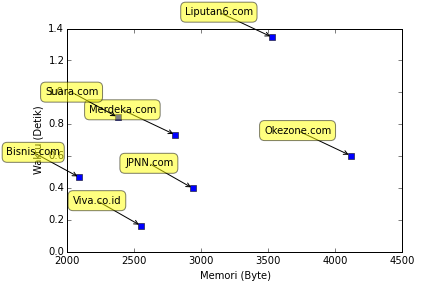

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = [1,2,3,5,6,7,8]
labels = ['Viva.co.id',  'Merdeka.com', 'Liputan6.com', 'Okezone.com', 'JPNN.com', 'Suara.com', 'Bisnis.com']
y1 = [DATACrawl[DATACrawl.sumber == i].crawlMem.mean() for i in x]
y2 = [DATACrawl[DATACrawl.sumber == i].crawlTime.mean() for i in x]

plt.plot(y1, y2,'s')
plt.xlabel('Memori (Byte)', fontsize=10)
plt.ylabel('Waktu (Detik)', fontsize=10)
for label, x, y in zip(labels, y1, y2):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
plt.show()

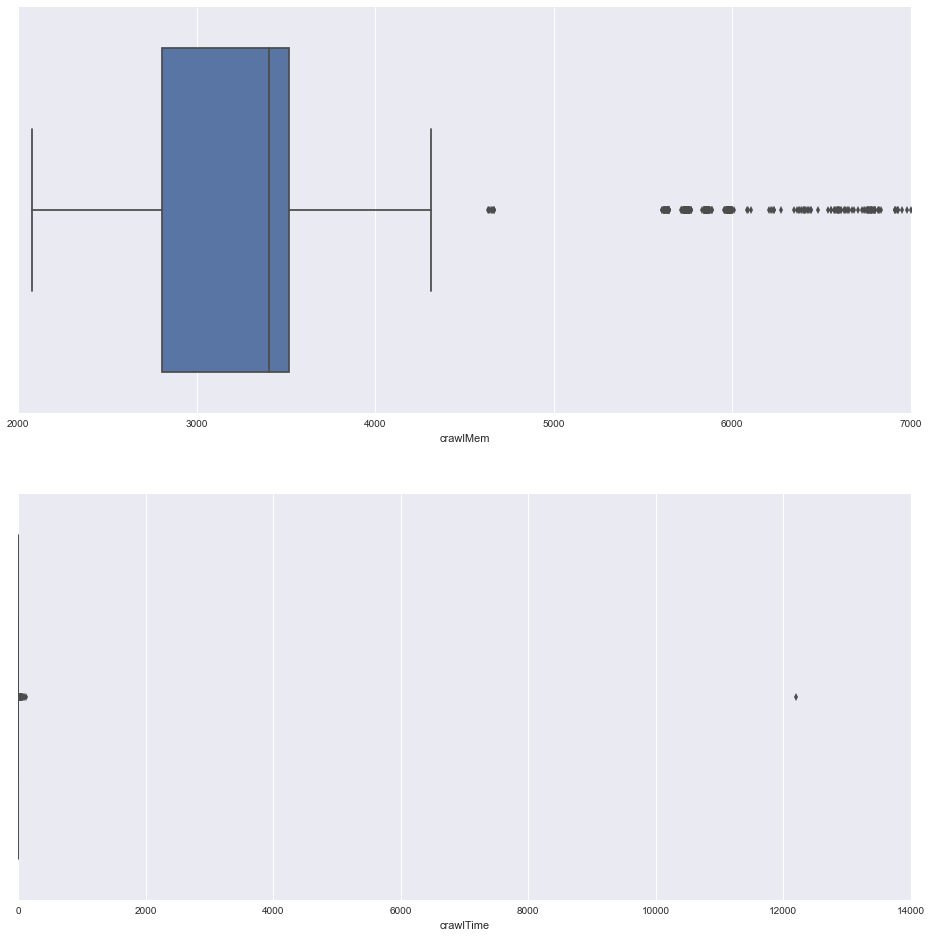

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,figsize=(16,16))

sns.boxplot(crawlIndicator.crawlMem, orient = 'h',ax=ax[0])
sns.boxplot(crawlIndicator.crawlTime, orient = 'h', ax=ax[1])

plt.show()

#### Terlihat total penggunaan waktu dan memory sangat signifikan, hal tersebut karena jumlah berita positif dan negatif yang berbeda jauh

# 2.Evaluating the Classifier v1.4 vs v1.6 vs v2.0


## 2.1 Load from the 'Pickled' dump

In [6]:
DATAStd  = pd.DataFrame()
DATAPost = pd.DataFrame()

#Load standard striped Text
%time DATAStd['Judul'] = pickle.load( open( "v1.4\DATA_JUDULStriped-v2.p", "rb" ) )
%time DATAStd['Short'] = pickle.load( open( "v1.4\DATA_SHORTStriped-v2.p", "rb" ) )
%time DATAStd['Long']  = pickle.load( open( "v1.4\DATA_LONGStriped-v2.p", "rb" ) )

#Load from PosTagged Noun and verb only Text
%time DATAPost['Judul'] = pickle.load( open( "v1.6\DATA_JUDULpostag-v2.p", "rb" ) )
%time DATAPost['Short'] = pickle.load( open( "v1.6\DATA_SHORTpostag-v2.p", "rb" ) )
%time DATAPost['Long']  = pickle.load( open( "v1.6\DATA_LONGpostag-v2.p", "rb" ) )

#Load number of total tag in Text
%time AllFracJudul = pickle.load( open( "v2.0\DATA_JUDUL-v3.p", "rb" ) )
%time AllFracShort = pickle.load( open( "v2.0\DATA_SHORT-v3.p", "rb" ) )
%time AllFracLong  = pickle.load( open( "v2.0\DATA_LONG-v3.p", "rb" ) )

#Load number of total noun-verb only in Text
# %time NVFracJudul = pickle.load( open( "v2.0\DATA_JUDUL-v2.p", "rb" ) )
# %time NVFracShort = pickle.load( open( "v2.0\DATA_SHORT-v2.p", "rb" ) )
# %time NVFracLong  = pickle.load( open( "v2.0\DATA_LONG-v2.p", "rb" ) )

%time DATA_TARGET = pickle.load( open( "v1.4\DATA_TARGET-v2.p", "rb" ) )

DATA_TARGET = DATA_TARGET.reset_index(drop=True)
DATAStd  = DATAStd.reset_index(drop=True)
DATAPost = DATAPost.reset_index(drop=True)

Wall time: 411 ms
Wall time: 371 ms
Wall time: 4.05 s
Wall time: 247 ms
Wall time: 313 ms
Wall time: 2.23 s
Wall time: 1.17 s
Wall time: 1.38 s
Wall time: 1.08 s
Wall time: 116 ms


In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

vect1 = TfidfVectorizer(decode_error='ignore')
vect2 = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')

vectStds = vect1.fit_transform(DATAStd['Long'])
vectStop = vect2.fit_transform(DATAStd['Long'])
vectPost = vect1.fit_transform(DATAPost['Long'])

In [121]:
vectStds

<28579x138759 sparse matrix of type '<type 'numpy.float64'>'
	with 4863997 stored elements in Compressed Sparse Row format>

In [132]:
vectStop.get_shape()

(28579, 138048)

In [112]:
vectPost

<28579x130162 sparse matrix of type '<type 'numpy.float64'>'
	with 3456038 stored elements in Compressed Sparse Row format>

In [9]:
print AllFracLong.shape

(28579L, 29L)


#### Data Teks berita yang sudah dibersihkan dari tag HTML di v1.4

In [10]:
DATAStd.Judul.head(2)

0    tiba di kpk, bos agung sedayu group diam serib...
1    edarkan ganja ke nelayan  &  pelajar, kardiman...
Name: Judul, dtype: object

#### Data Teks berita yang sudah di-POSTag verb dan noun di v1.6

In [105]:
DATAPost.Judul.head(2)

0    tiba kpk bos agung sedayu group diam seribu ba...
1    edarkan ganja nelayan pelajar kardiman ditangk...
Name: Judul, dtype: object

#### Data Teks berita yang sudah diambil fraction verb dan noun di v2.0

In [12]:
AllFracJudul[:2]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

## 2. Evaluate

### Preprocessing

![smiley](img/evaluasi_preproc.png)

In [13]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [14]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score,roc_curve,auc
from scipy import interp
import datetime

def skorStratCV(clf,X,y,nfolds=10):
    metrics = []
    
    trainTime,testTime = [],[]
    precis,recals,f1s,accs,rocs = [],[],[],[],[]
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    skf = cross_validation.StratifiedKFold(y, n_folds=nfolds)
    for train_index, test_index in skf:
        X_train,y_train = X[train_index],y[train_index]
        X_test,y_test   = X[test_index],y[test_index]
        
        #training time
        start = dt.now()
        clf.fit(X_train, y_train)
        end = dt.now()
        trainTime.append((end-start).microseconds)
        
        #testing time
        start = dt.now()
        yhat = clf.predict(X_test)
        end = dt.now()
        testTime.append((end-start).microseconds)
        
        #score
        precis.append(precision_score(y_test, yhat, average='binary'))
        recals.append(recall_score(y_test, yhat, average='binary'))
        f1s.append(f1_score(y_test, yhat, average='binary'))
        accs.append(accuracy_score(y_test, yhat))
        
        probas_              = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr            += interp(mean_fpr, fpr, tpr)
        mean_tpr[0]          = 0.0
        
    def ave(lis):
        return sum(lis)/len(lis)
    
    metrics.append(ave(trainTime))
    metrics.append(ave(testTime))
    metrics.append(ave(precis))
    metrics.append(ave(recals))
    metrics.append(ave(f1s))
    metrics.append(ave(accs))
    
    mean_tpr /= nfolds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    metrics.append(mean_auc)
    
    return metrics,mean_fpr,mean_tpr

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

mnb = MultinomialNB(alpha=0.1)
#knn = KNeighborsClassifier()
svc = SVC(class_weight='balanced',probability=True,kernel='linear',cache_size=800)
#tre = DecisionTreeClassifier(class_weight='balanced')

vectStds = TfidfVectorizer(decode_error='ignore')
vectStop = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')

kombinasi1  = [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vectStds),('clf', mnb)])},
               #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
               {'name' : 'SVM', 'pipe' : Pipeline([('vect', vectStds),('clf', svc)])},
               #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
              ]

kombinasi23= [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vectStop),('clf', mnb)])},
             #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
             {'name' : 'SVM', 'pipe' : Pipeline([('vect', vectStop),('clf', svc)])},
             #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
             ]

kombinasi4 = [{'name' : 'MNB', 'pipe' : mnb},
               {'name' : 'SVM', 'pipe' : svc},
             ]

In [18]:
X0 = []
X0.append({'name':'Judul','Prep':'Kombinasi1','Data':DATAStd['Judul']})
X0.append({'name':'Short','Prep':'Kombinasi1','Data':DATAStd['Short']})
X0.append({'name':'Long' ,'Prep':'Kombinasi1','Data':DATAStd['Long']})

X1 = []
X1.append({'name':'Judul','Prep':'Kombinasi2','Data':DATAStd['Judul']})
X1.append({'name':'Short','Prep':'Kombinasi2','Data':DATAStd['Short']})
X1.append({'name':'Long' ,'Prep':'Kombinasi2','Data':DATAStd['Long']})

X2 = []
X2.append({'name':'Judul','Prep':'Kombinasi3','Data':DATAPost['Judul']})
X2.append({'name':'Short','Prep':'Kombinasi3','Data':DATAPost['Short']})
X2.append({'name':'Long' ,'Prep':'Kombinasi3','Data':DATAPost['Long']})

X3 = []
X3.append({'name':'Judul','Prep':'Kombinasi4','Data':AllFracJudul})
X3.append({'name':'Short','Prep':'Kombinasi4','Data':AllFracShort})
X3.append({'name':'Long' ,'Prep':'Kombinasi4','Data':AllFracLong})
# X2.append({'name':'Judul','Prep':'NVTag','Data':NVFracJudul})
# X2.append({'name':'Short','Prep':'NVTag','Data':NVFracShort})
# X2.append({'name':'Long' ,'Prep':'NVTag','Data':NVFracLong})

y_  = DATA_TARGET

Total Negative Instances    :  28459
Training Negative Instances :  569
Training Positif Instances  :  120


## Kombinasi 1

In [134]:
for i in X0:
    k     = vect1.fit_transform(i['Data'])
    print k.get_shape()

(28579, 17453)
(28579, 25070)
(28579, 138759)


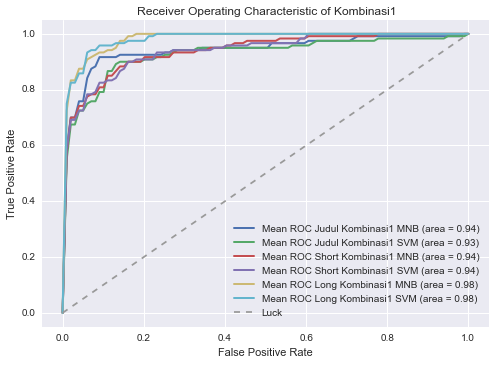

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

metric = []
for xi in X0:
    X_ = xi['Data']
    for mod in kombinasi1:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi1')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 2

In [135]:
for i in X1:
    k     = vect2.fit_transform(i['Data'])
    print k.get_shape()

(28579, 17016)
(28579, 24483)
(28579, 138048)


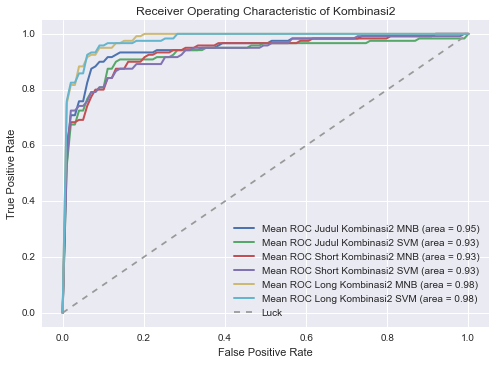

In [20]:
#metric = []
for xi in X1:
    X_ = xi['Data']
    for mod in kombinasi23:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi2')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 3

In [136]:
for i in X2:
    k     = vect2.fit_transform(i['Data'])
    print k.get_shape()

(28579, 15903)
(28579, 23214)
(28579, 129645)


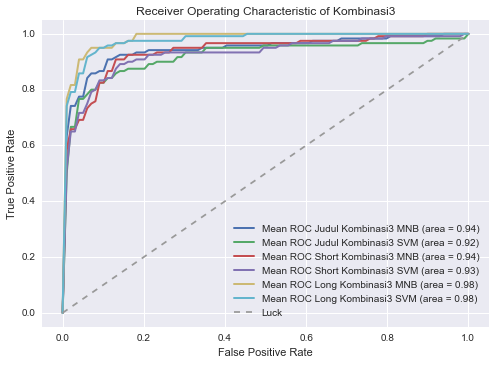

In [21]:
#metric = []
for xi in X2:
    X_ = xi['Data']
    for mod in kombinasi23:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi3')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 4

C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


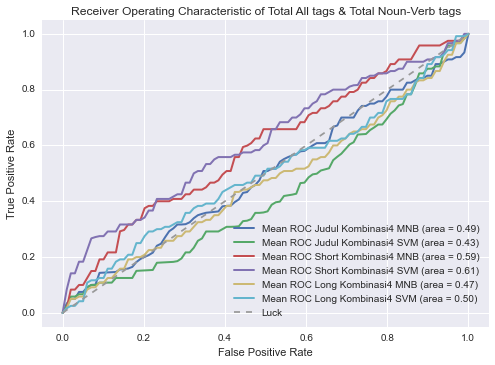

In [22]:
#metric = []
for xi in X3:
    X_ = xi['Data']
    for mod in kombinasi4:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.vstack((xP,xN))
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Total All tags & Total Noun-Verb tags')
plt.legend(loc="lower right")
plt.show()

In [23]:
from ipy_table import *
metrics_table = []
tables = []
columns = (['id', 'nama','training time', 'testing time','p_1',
            'r_1','F1 score','accuracy','AUC'])
tables.append(columns)

i = 0

for me in metric:
    i += 1
    
    metr = []
    metr.append(i)
    metr.append(me['name'])
    for m in me['metrics']:
        metr.append(m)

    tables.append(metr)
    metrics_table.append(metr)
    #print metric
    
make_table(tables)

# styling
apply_theme('basic_both')
set_column_style(7, align='center')

id,nama,training time,testing time,p_1,r_1,F1 score,accuracy,AUC
1,Judul Kombinasi1 MNB,21800,4600,0.8576,0.7833,0.8042,0.9346,0.9411
2,Judul Kombinasi1 SVM,263900,6300,0.7742,0.7583,0.7473,0.9114,0.9261
3,Short Kombinasi1 MNB,27700,2900,0.8250,0.6667,0.7227,0.9129,0.9379
4,Short Kombinasi1 SVM,337600,9200,0.8325,0.7167,0.7625,0.9231,0.9377
5,Long Kombinasi1 MNB,324300,32800,0.9243,0.7500,0.8219,0.9462,0.9801
6,Long Kombinasi1 SVM,416000,83900,0.9181,0.8250,0.8636,0.9564,0.9801
7,Judul Kombinasi2 MNB,20000,2600,0.7987,0.7917,0.7843,0.9245,0.9466
8,Judul Kombinasi2 SVM,255200,5400,0.7448,0.7583,0.7360,0.9056,0.9269
9,Short Kombinasi2 MNB,26300,3000,0.8135,0.7167,0.7565,0.9202,0.9343
10,Short Kombinasi2 SVM,258200,5200,0.8008,0.7583,0.7735,0.9216,0.9304


In [24]:
evals = pd.DataFrame(metrics_table,columns=columns)
evals['Vars'] = [i.split()[0] for i in evals['nama']]
evals['Prep'] = [i.split()[1] for i in evals['nama']]
evals['Algs'] = [i.split()[2] for i in evals['nama']]
evals.drop('nama',axis=1,inplace=True)
evals.drop('id',axis=1,inplace=True)

In [115]:
evals

,training time,testing time,p_1,r_1,F1 score,accuracy,AUC,Vars,Prep,Algs
0,21800,4600,0.857632,0.783333,0.804175,0.934612,0.941077,Judul,Kombinasi1,MNB
1,263900,6300,0.774242,0.758333,0.747303,0.911402,0.926094,Judul,Kombinasi1,SVM
2,27700,2900,0.825036,0.666667,0.722741,0.912894,0.937879,Short,Kombinasi1,MNB
3,337600,9200,0.832451,0.716667,0.762457,0.923082,0.937710,Short,Kombinasi1,SVM
4,324300,32800,0.924318,0.750000,0.821852,0.946249,0.980051,Long,Kombinasi1,MNB
5,416000,83900,0.918100,0.825000,0.863628,0.956415,0.980051,Long,Kombinasi1,SVM
6,20000,2600,0.798713,0.791667,0.784309,0.924467,0.946633,Judul,Kombinasi2,MNB
7,255200,5400,0.744774,0.758333,0.736040,0.905627,0.926852,Judul,Kombinasi2,SVM
8,26300,3000,0.813467,0.716667,0.756509,0.920162,0.934343,Short,Kombinasi2,MNB
9,258200,5200,0.800838,0.758333,0.773515,0.921611,0.930387,Short,Kombinasi2,SVM


In [25]:
splitter1 = ['Judul','Short','Long']
splitter2 = ['Kombinasi1','Kombinasi2','Kombinasi3']
eval_teks = evals[evals.Prep.isin(splitter2)]
eval_teks = pd.DataFrame([eval_teks[eval_teks.Vars == i].mean() for i in splitter1]).transpose()
eval_teks.set_axis(1,splitter1)
eval_teks

,Judul,Short,Long
training time,127466.666667,147633.333333,379300.000000
testing time,4333.333333,4716.666667,50233.333333
p_1,0.792390,0.810344,0.914283
r_1,0.777778,0.719444,0.804167
F1 score,0.771393,0.754880,0.849759
accuracy,0.920368,0.919199,0.953019
AUC,0.933670,0.933572,0.979363


In [26]:
splitter = ['Kombinasi1','Kombinasi2','Kombinasi3','Kombinasi4']
eval_prep = pd.DataFrame([evals[evals.Prep == i].mean() for i in splitter]).transpose()
eval_prep.set_axis(1,splitter)
eval_prep

,Kombinasi1,Kombinasi2,Kombinasi3,Kombinasi4
training time,231883.333333,204916.666667,217600.000000,124300.000000
testing time,23283.333333,19466.666667,16533.333333,900.000000
p_1,0.855297,0.831616,0.830105,0.143342
r_1,0.750000,0.772222,0.779167,0.247222
F1 score,0.787026,0.791348,0.797659,0.148290
accuracy,0.930776,0.929810,0.932001,0.675313
AUC,0.950477,0.949523,0.946605,0.516768


In [27]:
splitter1 = ['MNB','SVM']
splitter2 = ['Kombinasi1','Kombinasi2','Kombinasi3']
eval_teks = evals[evals.Prep.isin(splitter2)]
eval_teks = pd.DataFrame([eval_teks[eval_teks.Algs == i].mean() for i in splitter1]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

In [53]:
mnb

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [28]:
#knn
# knn_params = {'n_neighbors': range(1,21), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'],
#               'leaf_size': [15, 30, 50, 100], 'p': [1,2]}

In [54]:
svc
# lsvm_params = {'loss':['hinge', 'squared_hinge'],'class_weight':['balanced']}

SVC(C=1.0, cache_size=800, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#tre
# tree_param = {"criterion": ["gini", "entropy"],"class_weight" : ['balanced']}